In [1]:
import numpy as np
import pandas as pd
import subprocess, os
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from collections import Counter

import seaborn as sns
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

from smer import load_smer_data, sdist_kmers, get_smer_count
smer_dir = "../data/"

from Bio.SeqIO.FastaIO import SimpleFastaParser
from Bio import AlignIO
import Bio.motifs as bm
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC, Gapped
import subprocess, os, re

import time

In [4]:
# JASPAR sites file
# contains all instances
# semi-conserved motif core is capitalized, serves as alignment
# cut sequences and leave only capitalized part
# read into pandas dataframe
# create motifs file for consensus/pwm

def read_fasta_to_df(fname):
    '''not real fasta due to duplicate headers'''
    with open(fname) as fasta_file:  # Will close handle cleanly
        ids = []
        seqs = []
        for title, sequence in SimpleFastaParser(fasta_file):
            ids.append(title)
            seqs.append(sequence)
    df = pd.DataFrame([ids,seqs]).transpose()
    df.columns = ['id','seq']
    return df

mypath = '../data/sites'

#fnames = os.listdir(folder)
seqs_list = []
fignore = '.DS_Store'

for fname in [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]:
    #print(fname)
    if fname[9:] not in fignore:
        # append df from fasta containg headers and seqs as well as fname as motif data
        df = read_fasta_to_df(mypath+'/'+fname)
        df['motif_id'] = '.'.join(fname.split('.')[:-1])
        seqs_list.append(df)
    
seqsframe = pd.concat(seqs_list,axis=0)
seqsframe.head()

,id,seq,motif_id
0,tair10_chr5:26036348-26036358(+),cattggatcgtgagcttcttataaacaaacccagacaaatcttgca...,MA1079.1
1,tair10_chr1:17627530-17627540(+),agccatcctagtggatcatatgtgtttaatcaatcgaaagcatgat...,MA1079.1
2,tair10_chr5:19632630-19632640(+),ggaaaccattggagaagaaggtttttggtatcgtaaaggtttgaac...,MA1079.1
3,tair10_chr2:1041488-1041498(-),ttcttaattatcaccaaaaccccaaaaccaactaaaactgaaaaaa...,MA1079.1
4,tair10_chr5:2820524-2820534(+),tagagttctctggaaatgaatagacttttgacgtaaaaggtgtaat...,MA1079.1


(1914239, 3)
59
(871,)
(413989, 5)
(1815644, 5)
56
(871,)
(315142, 5)
(1815644, 7)
(1795440, 7)
0


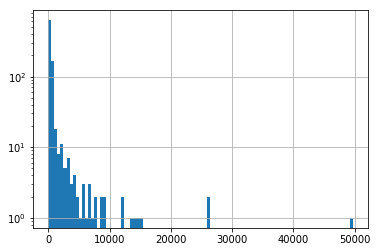

In [5]:
## filter sequences to semi-conserved motif sites

print(seqsframe.shape)
seqsframe = seqsframe.reset_index(drop=True)
seqsframe['motif_seq'] = seqsframe.seq.apply(lambda x: re.sub(r'[a-z]', '', x))
seqsframe['motif_len'] = seqsframe.motif_seq.str.len()
seqsframe.groupby('motif_id')['motif_seq'].nunique().hist(bins=100)
plt.yscale('log')
plt.show

## correct lengths

# sanity check equal length
print(sum(seqsframe.groupby('motif_id')['motif_len'].nunique() > 1))

# # filter from initial df based on groupby
grouped = seqsframe.groupby('motif_id')
print(grouped['motif_len'].mean().shape)
df_not_len = grouped.filter(lambda x: x['motif_len'].nunique() > 1)
print(df_not_len.shape)

# analysis of this frame reveals empty sequences, remove these
seqsframe = seqsframe[seqsframe.motif_len > 0]
print(seqsframe.shape)

# sanity check equal length
print(sum(seqsframe.groupby('motif_id')['motif_len'].nunique() > 1))

# # filter from initial df based on groupby
grouped = seqsframe.groupby('motif_id')
print(grouped['motif_len'].mean().shape)
df_not_len = grouped.filter(lambda x: x['motif_len'].nunique() > 1)
print(df_not_len.shape)

# all sequences len = median
# any deviation from median can be removed
df_not_len.groupby('motif_id')['motif_len'].describe().head()

# store medain-len per motif group in original frame, then filter any deviations
# store groupby median
df_median = grouped['motif_len'].median().reset_index()
df_median.columns = ['motif_id','motif_median']
# join
seqsframe2 = pd.concat([seqsframe.set_index('motif_id'),df_median.set_index('motif_id')], axis=1, join='inner').reset_index()
seqsframe2['median_diff'] = np.abs(seqsframe2.motif_len-seqsframe2.motif_median)
print(seqsframe2.shape)
seqsframe3 = seqsframe2[seqsframe2.median_diff == 0]
print(seqsframe3.shape)

# verify
# sanity check equal length
print(sum(seqsframe3.groupby('motif_id')['motif_len'].nunique() > 1))


(1413618, 8)
(835, 7)
(1301250, 8)


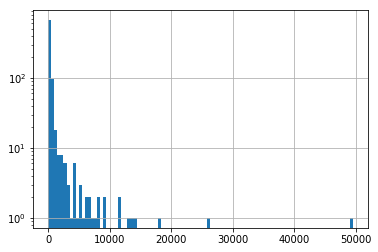

In [6]:
## filter out non-ACGT sequnces

seqsframe3['motif_char'] = seqsframe3.motif_seq.apply(set)
seqsframe4 = seqsframe3[seqsframe3.motif_char == {'A','C','G','T'}]
print(seqsframe4.shape)
seqsframe4.groupby('motif_id')['motif_seq'].nunique().hist(bins=100)
plt.yscale('log')
plt.show
print(seqsframe4.groupby('motif_id').count().shape)

# filter at least 10 sequnces 
grouped = seqsframe4.groupby('motif_id')
seqsframe4 = grouped.filter(lambda x: x['motif_seq'].nunique() >= 10)
print(seqsframe4.shape)

<function matplotlib.pyplot.show(*args, **kw)>

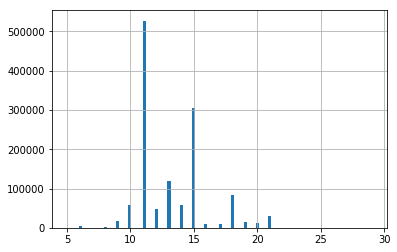

In [7]:
## Analyse motif sizes

seqsframe4.motif_len.hist(bins=100)
plt.show

In [8]:
print(seqsframe4.motif_len.describe())
# if we take 10, how much percent of data do we cover?
# print(seqsframe4[seqsframe4.motif_len >= 5].shape[0] / seqsframe4.shape[0])
# print(seqsframe4[seqsframe4.motif_len >= 6].shape[0] / seqsframe4.shape[0])
# print(seqsframe4[seqsframe4.motif_len >= 7].shape[0] / seqsframe4.shape[0])
# print(seqsframe4[seqsframe4.motif_len >= 8].shape[0] / seqsframe4.shape[0])
print(seqsframe4[seqsframe4.motif_len >= 9].shape[0] / seqsframe4.shape[0])
# print(seqsframe4[seqsframe4.motif_len >= 10].shape[0] / seqsframe4.shape[0])
# print(seqsframe4[seqsframe4.motif_len >= 11].shape[0] / seqsframe4.shape[0])
# print(seqsframe4[seqsframe4.motif_len >= 20].shape[0] / seqsframe4.shape[0])

# motifs of length 9 and above, so all codes can be analysed
print(seqsframe4[seqsframe4.motif_len>8].shape)

count    1.301250e+06
mean     1.316599e+01
std      2.784813e+00
min      5.000000e+00
25%      1.100000e+01
50%      1.200000e+01
75%      1.500000e+01
max      2.900000e+01
Name: motif_len, dtype: float64
0.9964680115273775
(1296654, 8)


In [9]:
print(seqsframe4[seqsframe4.motif_len>8].motif_id.unique().shape)
seqsframe4[seqsframe4.motif_len>8].head()

(595,)


,motif_id,id,seq,motif_seq,motif_len,motif_median,median_diff,motif_char
0,MA1079.1,tair10_chr5:26036348-26036358(+),cattggatcgtgagcttcttataaacaaacccagacaaatcttgca...,AAAAGTCAACG,11,11,0,"{T, C, G, A}"
1,MA1079.1,tair10_chr1:17627530-17627540(+),agccatcctagtggatcatatgtgtttaatcaatcgaaagcatgat...,AAAAGTCAACG,11,11,0,"{T, C, G, A}"
2,MA1079.1,tair10_chr5:19632630-19632640(+),ggaaaccattggagaagaaggtttttggtatcgtaaaggtttgaac...,AAAAGTCAACG,11,11,0,"{T, C, G, A}"
3,MA1079.1,tair10_chr2:1041488-1041498(-),ttcttaattatcaccaaaaccccaaaaccaactaaaactgaaaaaa...,CGTTGACTTTT,11,11,0,"{T, C, G, A}"
4,MA1079.1,tair10_chr5:2820524-2820534(+),tagagttctctggaaatgaatagacttttgacgtaaaaggtgtaat...,AAAAGTCAACG,11,11,0,"{T, C, G, A}"


# Compression ratio

3 4
(1296654, 8)
(508545, 8)


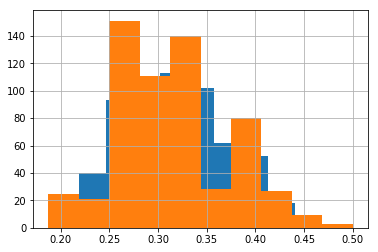

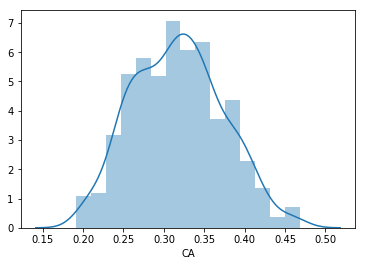

22


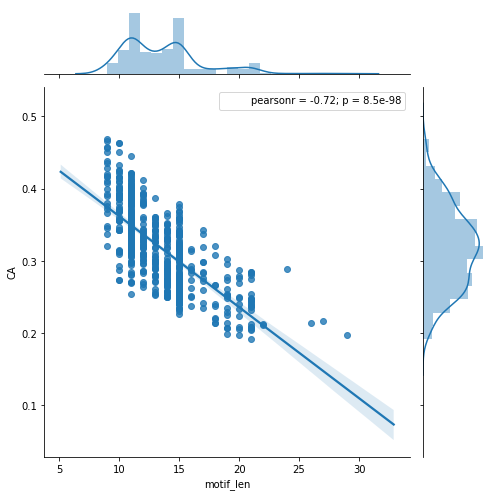

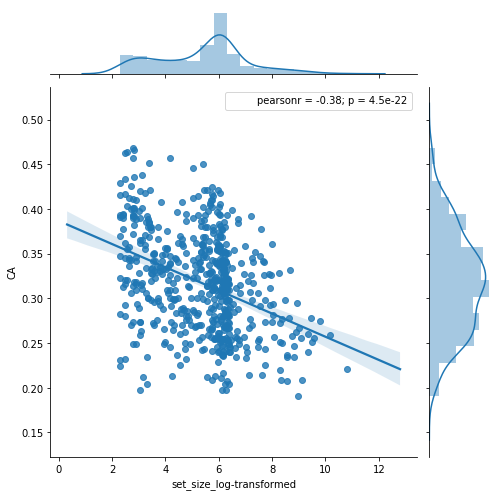

3 8
(1296654, 8)
(508545, 8)


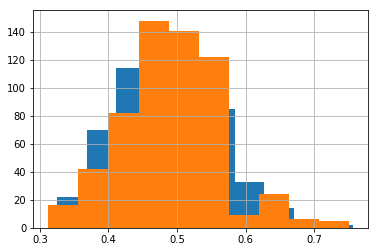

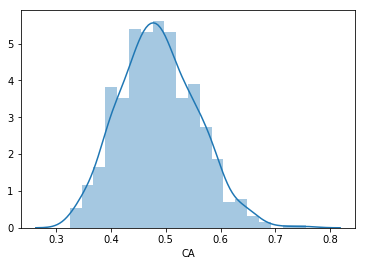

22


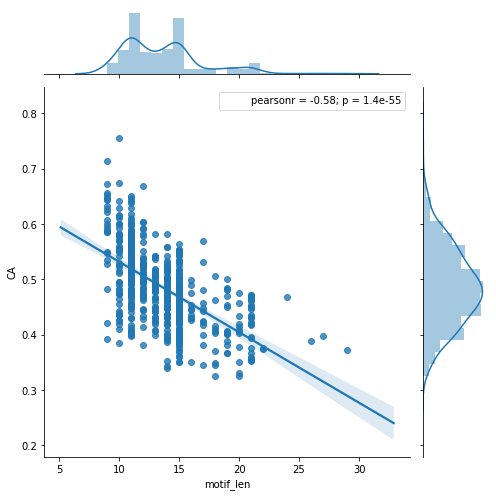

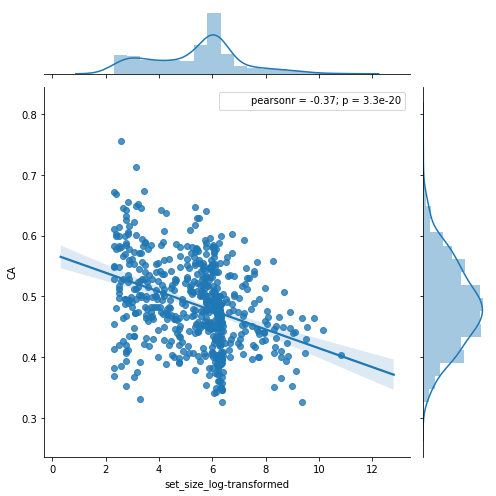

3 16
(1296654, 8)
(508545, 8)


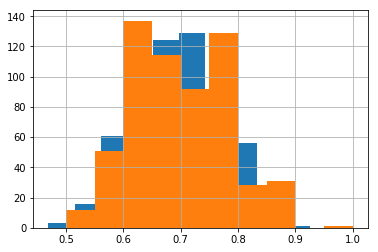

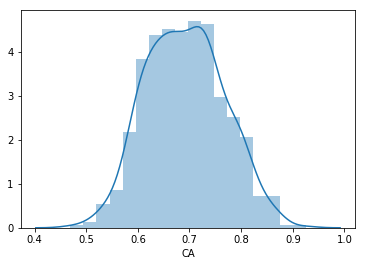

22


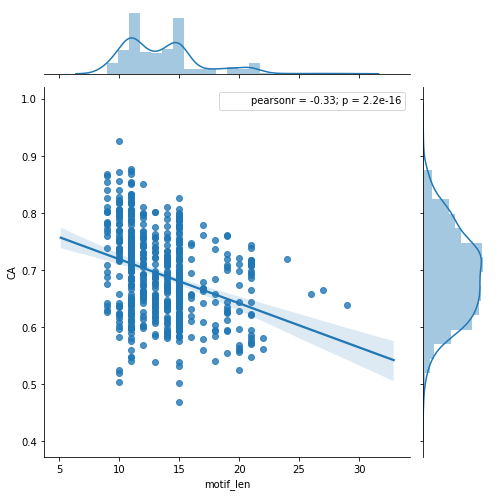

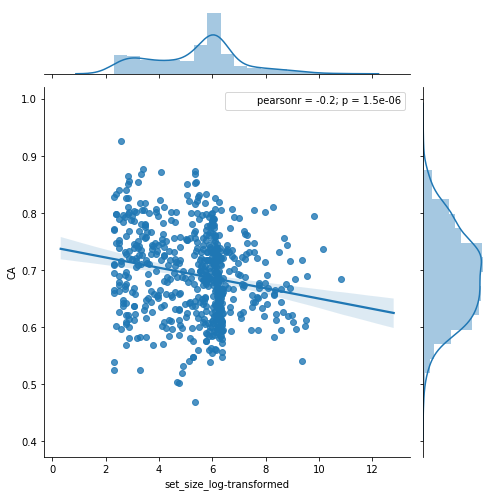

3 32
(1296654, 8)
(508545, 8)


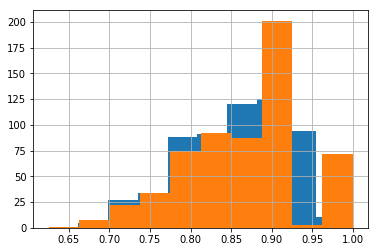

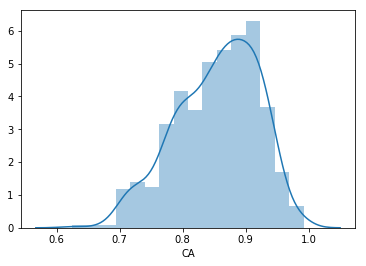

22


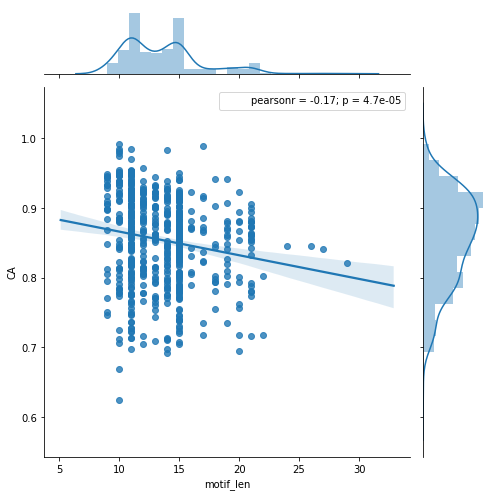

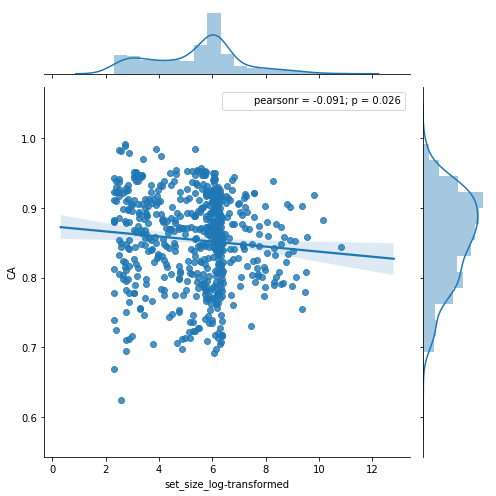

5 32
(1296654, 8)
(508545, 8)


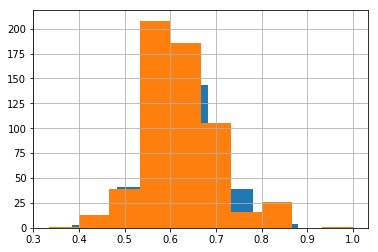

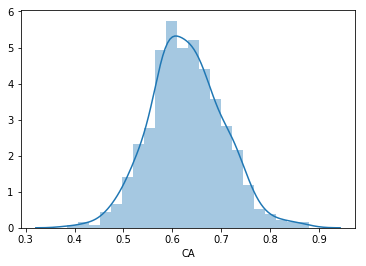

22


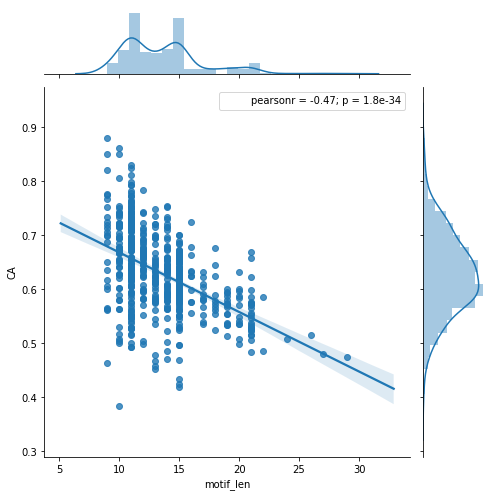

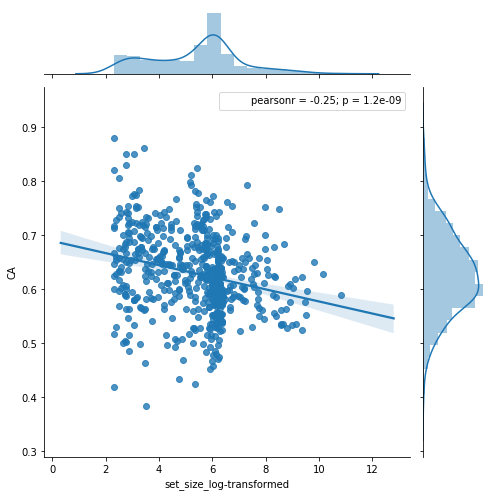

5 64
(1296654, 8)
(508545, 8)


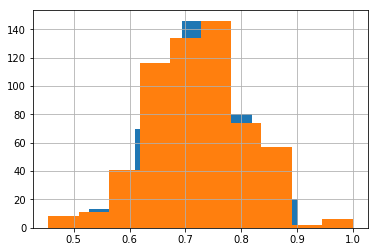

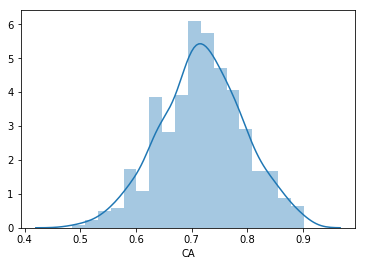

22


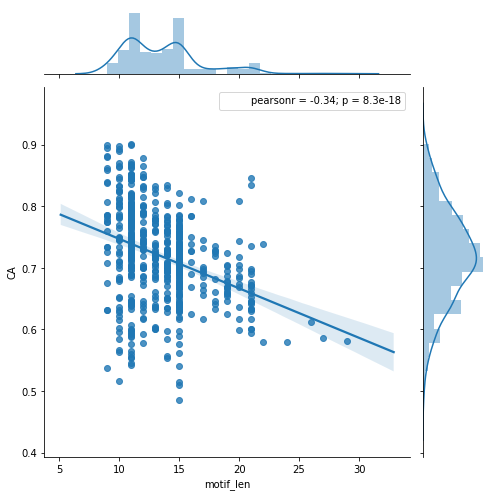

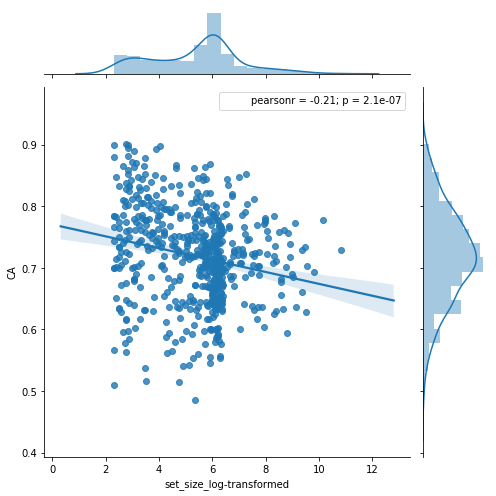

5 128
(1296654, 8)
(508545, 8)


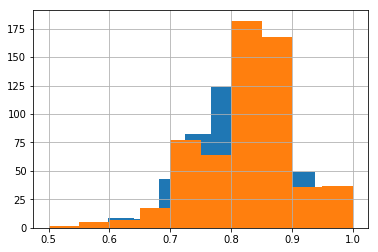

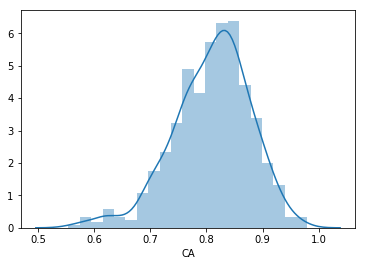

22


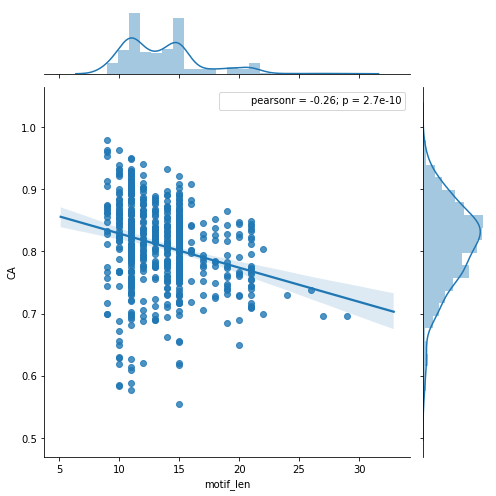

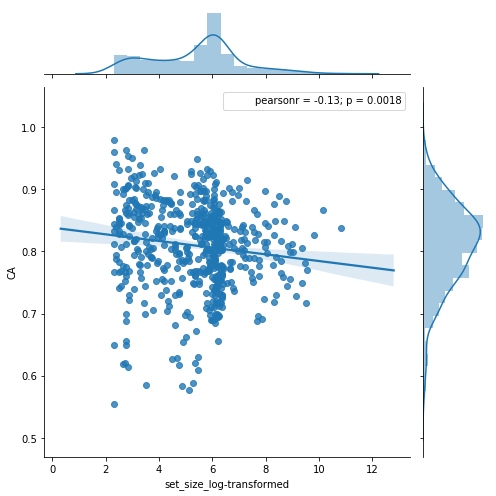

5 256
(1296654, 8)
(508545, 8)


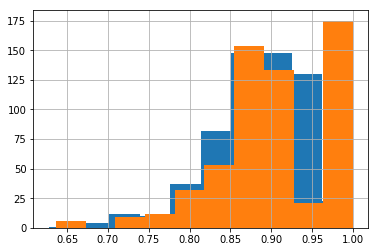

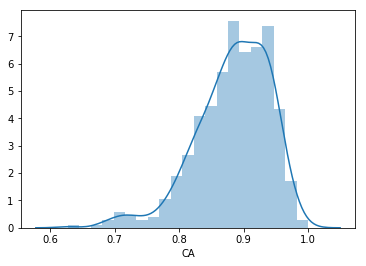

22


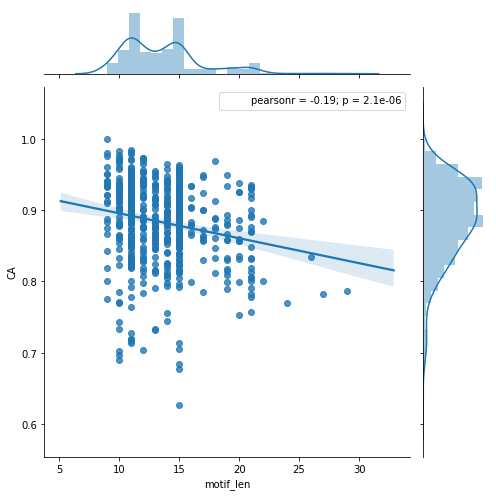

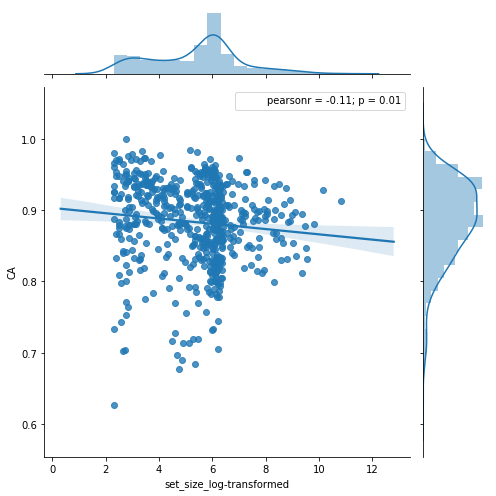

7 64
(1296654, 8)
(508545, 8)


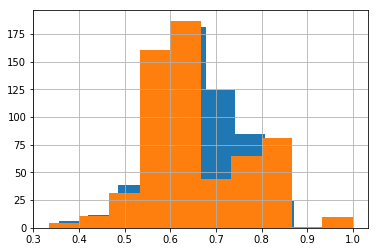

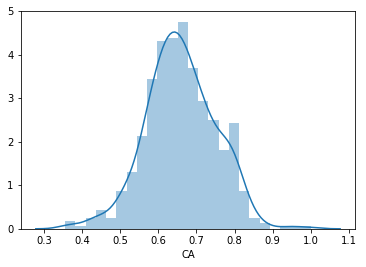

22


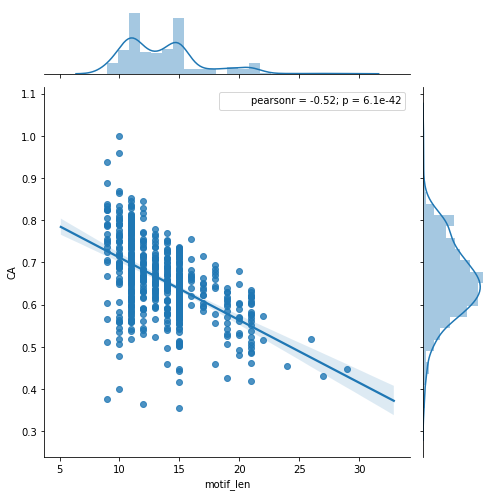

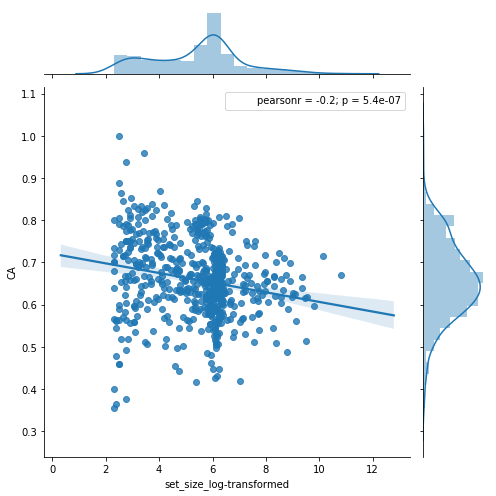

7 128
(1296654, 8)
(508545, 8)


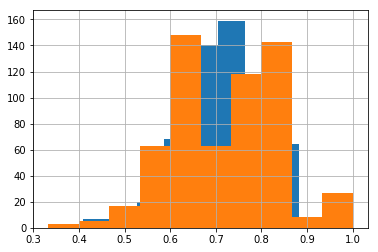

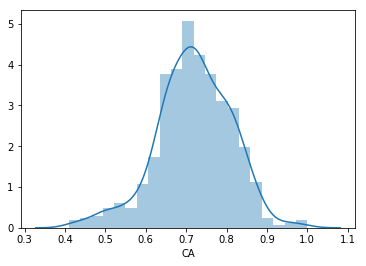

22


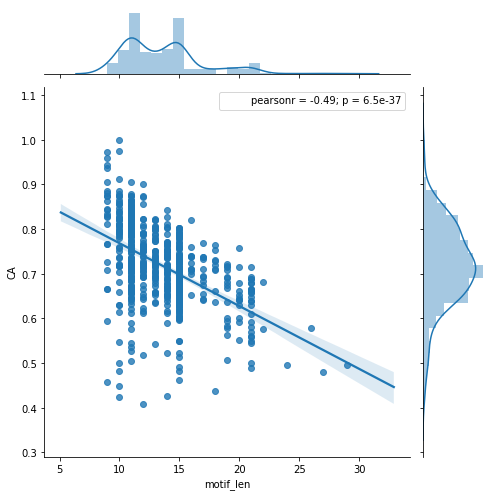

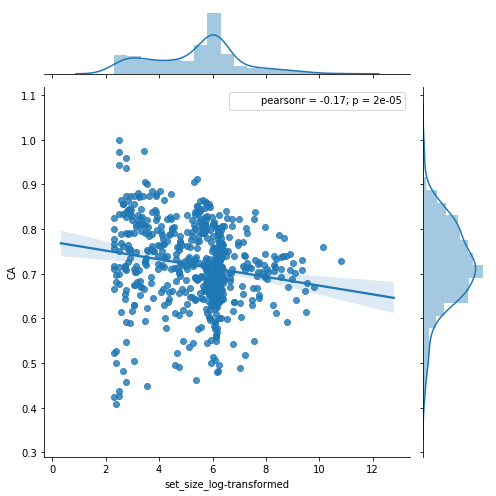

7 256
(1296654, 8)
(508545, 8)


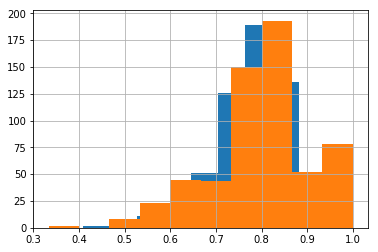

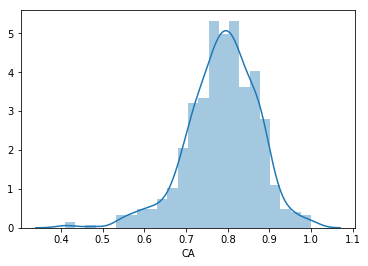

22


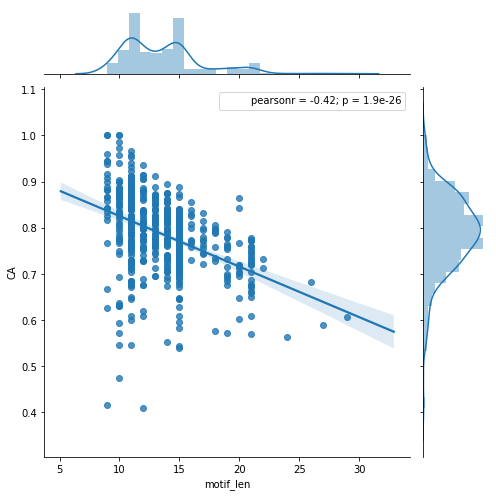

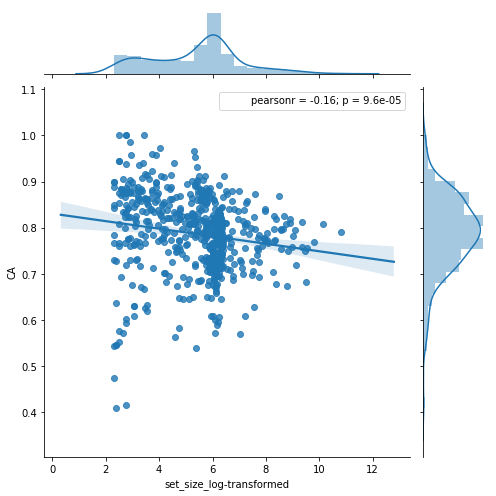

9 128
(1296654, 8)
(508545, 8)


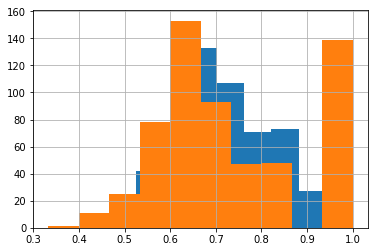

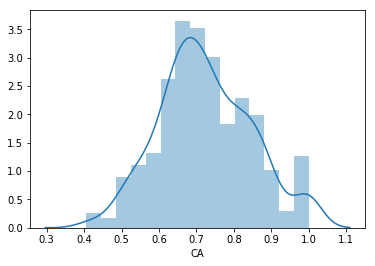

22


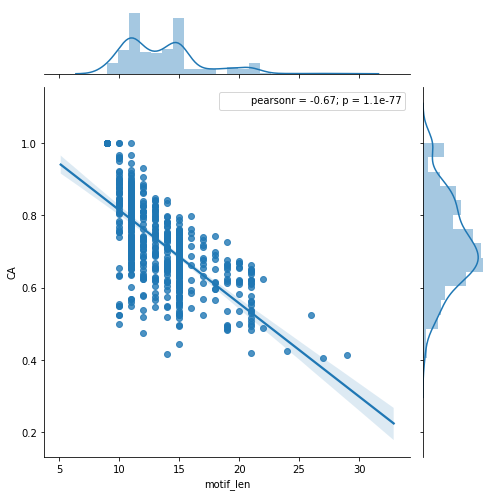

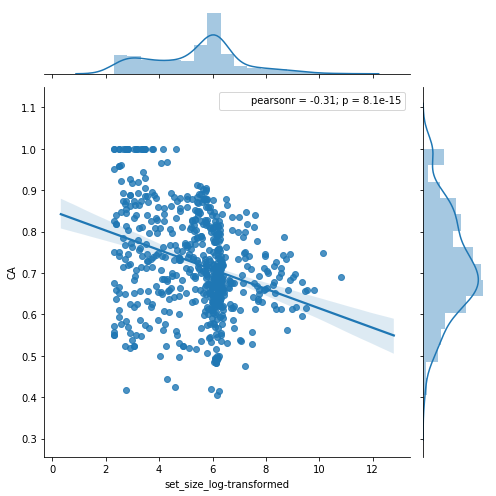

9 256
(1296654, 8)
(508545, 8)


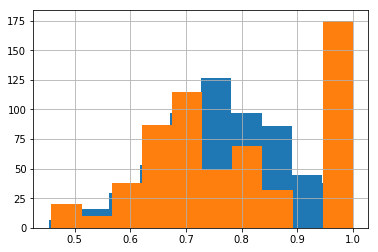

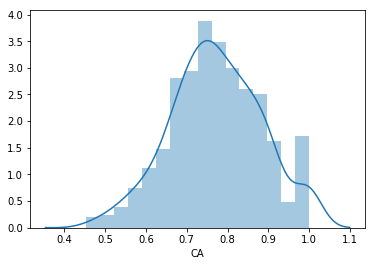

22


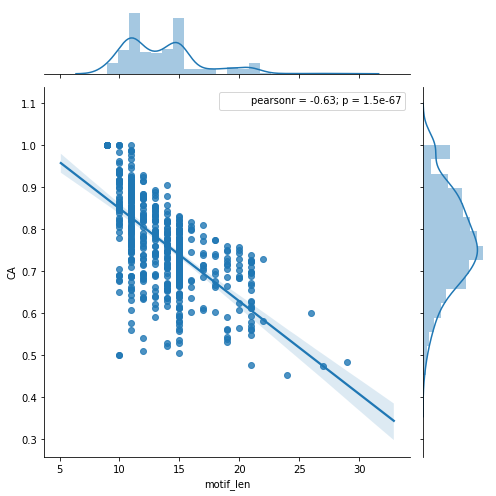

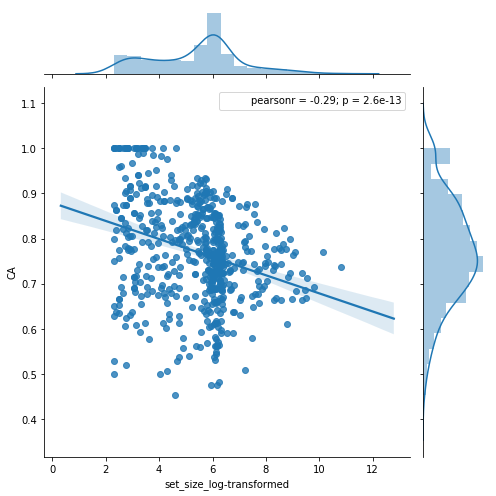

,k,clust,CA_mean,CA_std,PCC_len_CA,PCC_len_CA_pval,PCC_size_CA,PCC_size_CA_pval
0,3,4,0.317241,0.055808,-0.724226,8.488848e-98,-0.381730,4.457512e-22
1,3,8,0.486645,0.069934,-0.583480,1.428874e-55,-0.365167,3.305667e-20
2,3,16,0.691776,0.075367,-0.327958,2.191727e-16,-0.195992,1.453653e-06
3,3,32,0.853882,0.065386,-0.166105,4.670560e-05,-0.091090,2.629236e-02
4,5,32,0.629025,0.074620,-0.472892,1.753191e-34,-0.246133,1.164515e-09
5,5,64,0.718678,0.075193,-0.342386,8.306726e-18,-0.210838,2.096804e-07
6,5,128,0.809395,0.069096,-0.255065,2.730948e-10,-0.127814,1.784176e-03
7,5,256,0.883217,0.057949,-0.193205,2.057706e-06,-0.105004,1.037657e-02
8,7,64,0.659204,0.091992,-0.516801,6.145971e-42,-0.203766,5.369280e-07
9,7,128,0.718907,0.092415,-0.487902,6.547073e-37,-0.174065,1.958163e-05


In [11]:
## Experiment
folder = '../data/'

# def functions
def list_kmers(seq,k):
    return [seq[i:i+k] for i in range(len(seq)-k+1)]

smer_dict, smer_distmat = load_smer_data(smer_dir)

def get_smer_list(kmer_list,dic,k=5,c=64):
    '''convert kmer list to smer idx list'''
    k_conversion = np.array([3,5,7,9])
    clust_conversion = np.array([4,8,16,32,64,128,256])
    km = np.where(k_conversion == k)[0][0]
    cl = np.where(clust_conversion == c)[0][0]
    return [dic[km][cl][kmer] for kmer in kmer_list]

def get_key(my_dict, val): 
    return [key for key, value in my_dict.items() if val == value]

def smer_to_kmers(smer_list,dic,k,c):
    '''take all variants from dict idx'''
    k_conversion = np.array([3,5,7,9])
    clust_conversion = np.array([4,8,16,32,64,128,256])
    km = np.where(k_conversion == k)[0][0]
    cl = np.where(clust_conversion == c)[0][0]
    l = [get_key(dic[km][cl],smer) for smer in smer_list]
    return [item for sublist in l for item in sublist]
#smer_to_kmers([1,10,100],smer_dict,9,256)

def random_split(X1,split=0.1):
    '''split randomly seqs into train test'''
    X1 = np.array(X1)
    np.random.seed(seed=99)
    ind1 = np.random.permutation(np.linspace(0,X1.shape[0]-1,X1.shape[0],dtype='int32'))
    splt = (np.round(X1.shape[0]*split)-1).astype('int32')
    return X1[ind1[:splt]], X1[ind1[splt:]]


# stuff to store
# CA mean and variance
# PCC and pval for correlations 1 and 2

# def params
parset = [(3,4),(3,8),(3,16),(3,32),
          (5,32),(5,64),(5,128),(5,256),
          (7,64),(7,128),(7,256),
          (9,128),(9,256)]
df_parset = pd.DataFrame(parset, columns=['k','clust'])

k = 0
for par in parset:
    km = par[0]
    cl = par[1]
    print(km,cl)
    
    # motifs of length 9 and above, so all codes can be analysed
    df = seqsframe4[seqsframe4.motif_len>8] 
    print(df.shape)
    df = df.drop_duplicates(subset=['motif_id','motif_seq'])
    print(df.shape)

    df['kmer_list'] = df.motif_seq.apply(lambda x: list_kmers(x,k=km))
    df['smer_list'] = df.kmer_list.apply(lambda x: get_smer_list(x,smer_dict,k=km,c=cl))
    
    # compression ratio
    df['CA'] = df.apply(lambda x: len(set(x.smer_list))/len(set(x.kmer_list)), axis=1)
    df.groupby('motif_id')['CA'].mean().hist()
    df.groupby('motif_id')['CA'].median().hist()
    plt.show()
    
    df_parset.at[k,'CA_mean'] = df.groupby('motif_id')['CA'].mean().mean()
    df_parset.at[k,'CA_std'] = df.groupby('motif_id')['CA'].mean().std()
    
    # nicer hist
    sns.distplot(df.groupby('motif_id')['CA'].mean())
    plt.show()
    
    # how many datasets above 1000 size
    grouped = df.groupby('motif_id')
    sorted_sizes = grouped['CA'].count().sort_values(ascending=False)
    print(sum(sorted_sizes > 5000))
    
    # correlation lenght to compression ratio
    dfmean = pd.DataFrame(grouped.mean())
    g = sns.jointplot("motif_len", "CA", data=dfmean, kind="reg", height=7)
    g.annotate(stats.pearsonr)
    plt.show()
    df_parset.at[k,'PCC_len_CA'] = stats.pearsonr(dfmean.motif_len, dfmean.CA)[0]
    df_parset.at[k,'PCC_len_CA_pval'] = stats.pearsonr(dfmean.motif_len, dfmean.CA)[1]
    
    # size of dataset correlation?
    dfmean['set_size_log-transformed'] = grouped['CA'].count().apply(np.log)
    g = sns.jointplot("set_size_log-transformed", "CA", data=dfmean, kind="reg", height=7)
    g.annotate(stats.pearsonr)
    #plt.xscale('log')
    plt.show()
    df_parset.at[k,'PCC_size_CA'] = stats.pearsonr(dfmean['set_size_log-transformed'], dfmean.CA)[0]
    df_parset.at[k,'PCC_size_CA_pval'] = stats.pearsonr(dfmean['set_size_log-transformed'], dfmean.CA)[1]
    
    k+=1
    
df_parset.to_csv(folder+'TFBS_compression_pccs_29_4_19.csv',index=False)
df_parset

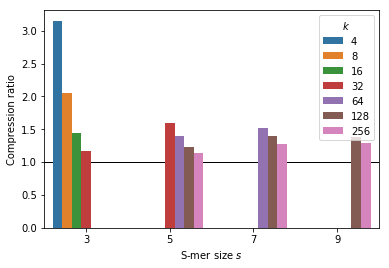

clust,4,8,16,32,64,128,256
k,,,,,,,
3,3.152182,2.054886,1.445555,1.171122,NaN,NaN,NaN
5,NaN,NaN,NaN,1.589761,1.391443,1.235491,1.132225
7,NaN,NaN,NaN,NaN,1.516982,1.391000,1.271044
9,NaN,NaN,NaN,NaN,NaN,1.381611,1.296022


In [12]:
# # analyse results
# invert compression ratio so it increases with higher compression

# test plot
df_parset['CA_mean_inv'] = df_parset.CA_mean.apply(lambda x: 1/x)
sns.barplot(data=df_parset,
           x='k',hue='clust',y='CA_mean_inv')
plt.plot([-1,4],[1,1],color='k',zorder=0,linewidth=1)
plt.xlim(-0.5,3.5)
plt.legend(loc=1,title='$k$')
plt.ylabel('Compression ratio')
plt.xlabel('S-mer size $s$')
plt.show()

df_parset.set_index(['k','clust']).CA_mean.apply(lambda x: 1/x).unstack()

In [13]:
# PCC compression ratio to motif length

print(df_parset.PCC_len_CA_pval.max())
df_parset.set_index(['k','clust']).PCC_len_CA.unstack()

4.670559659324133e-05


clust,4,8,16,32,64,128,256
k,,,,,,,
3,-0.724226,-0.58348,-0.327958,-0.166105,NaN,NaN,NaN
5,NaN,NaN,NaN,-0.472892,-0.342386,-0.255065,-0.193205
7,NaN,NaN,NaN,NaN,-0.516801,-0.487902,-0.417173
9,NaN,NaN,NaN,NaN,NaN,-0.666595,-0.631600


In [14]:
# PCC compression ratio to dataset size (num motifs per group)

print(df_parset.PCC_size_CA_pval.max())
df_parset.set_index(['k','clust']).PCC_size_CA.unstack()

0.02629236146244597


clust,4,8,16,32,64,128,256
k,,,,,,,
3,-0.38173,-0.365167,-0.195992,-0.091090,NaN,NaN,NaN
5,NaN,NaN,NaN,-0.246133,-0.210838,-0.127814,-0.105004
7,NaN,NaN,NaN,NaN,-0.203766,-0.174065,-0.159210
9,NaN,NaN,NaN,NaN,NaN,-0.311111,-0.293730


# Prediction potential

In [18]:
# functions
## load smer data into dictionaries of parameter values
def load_smer(direc = "../data/"):
    '''load smer data'''
    fn = []
    
    # read parameters
    fn.append(direc+"k3_idx.csv")
    fn.append(direc+"k5_idx.csv")
    fn.append(direc+"k7_idx.csv")
    fn.append(direc+"k9_idx.csv")
    print(fn[0])

    # make list of dictionaries of lists
    di = list()

    for i in range(0,4):
        data = pd.read_csv(fn[i],sep=',',header=None)
        data.set_index([0], drop=True, inplace=True)
        ditmp=[]
        for ii in range(0,data.shape[1]):
            ditmp.append(data.loc[:,ii+1].to_dict())
        di.append(ditmp)
    
    return di

## get smer
def get_smer(kmer_count,dic,k=5,c=64):
    '''kmer counts to smer counts'''
    
    # prerequisites
    k_conversion = np.array([3,5,7,9])
    clust_conversion = np.array([4,8,16,32,64,128,256])
    kmer = np.where(k_conversion == k)[0][0]
    clust = np.where(clust_conversion == c)[0][0]
    
    # smer indices
    idx = list(dic[kmer][clust].values())
    perms = np.unique(idx)
    smer_count = np.zeros((len(kmer_count),len(perms)))
    
    # can probably be vectorized
    for i in range(len(kmer_count)):
        for ii in range(len(kmer_count[0])):
            smer_count[i][idx[ii]-1] += kmer_count[i][ii]
    
    return smer_count    
    
## functions structural variants
# 11_11_2018: change names to more understandable

def get_k_from_i(i):
    return 2*(i+1)+1

def get_clust_from_i(i):
    return 2**(i+2)

def get_i_from_k(k):
    return int(((k-1)/2)-1)

def get_i_from_clust(k):
    return int(np.log2(k)-2)

def colors(seq,dic,k):
    '''sequence to s-code'''
    cz = []
    for i in range(len(seq)-k+1):
        x = seq[i:i+k]
        color = dic[x]
        cz.append(color)
    return cz

def initials(dic,colo): 
    '''find initial points'''
    intu=[]
    for x in dic:
        if dic[x] == colo:
            intu.append(x)
    return intu

def reconstructions(seq,dic,k):
    '''reconstruct sequence variants from s-code'''
    chars = "ACGT"
    intu = initials(dic,seq[0])
    nexttu = []
    for i in range(1,len(seq)):
        newc = seq[i]
        for tup in intu:
            x = tup[-k:]
            for c in chars:
                y = x[1:]+c
                w = dic[y]
                if w == newc:
                    newtup = tup+c
                    nexttu.append(newtup)
        intu = nexttu[:]
        nexttu = []
    return intu

# def hamming(s1,s2):
#     '''p-distance = hamming/length'''
#     d = 0
#     for i in range(len(s1)):
#         if s1[i] != s2[i]:
#             d += 1
#     return d

def hamming(in1,in2):
    '''p-distance = hamming/length
    takes integer input'''
    return np.count_nonzero(seq2int(in1)-seq2int(in2))

def seq2int(seq):
    '''sequence to integer'''
    alphabet = ['A','C','G','T','N']
    return np.array([np.where(np.isin(alphabet,x))[0][0] for x in seq])

# def seq2int_array(seq):
#     '''sequence list to integer'''
#     out = []
#     for x in seq:
#         out.append(seq2int(x))
#     return np.array(out)

def ham(li):
    '''hamming for sequence list'''
    n = len(li)
    mat = []
    for i in range(n):
        v =[]
        for j in range(n):
            d = hamming(li[i],li[j])
            v.append(d)
        mat.append(v)
    return mat

def euclid(c1,c2,dm):
    '''get s-distance from precomputed distance matrix'''
    d = 0
    for i in range(len(c1)):
        for j in range(len(c2)):
            d += dm[int(c1[i])-1][int(c2[j])-1]
    return d

def eucl(li,dm):
    '''s-distance for s-code list'''
    n = len(li)
    mat = []
    for i in range(n):
        v =[]
        for j in range(n):
            d = euclid(li[i],li[j],dm)
            v.append(d) 
        mat.append(v)
    return mat

def get_variants(seq,di,k):
    '''variants for instance of sequence and s-code parameters'''
    laz = colors(seq,di,k)
    re = reconstructions(laz,di,k)
    return re

sdict = load_smer()
len(sdict[3])

../data/k3_idx.csv


7

In [19]:
# largest motif groups
tmp = (seqsframe4[(seqsframe4.motif_len>8)]
 .groupby('motif_id')
 .motif_seq
 .nunique()
 .sort_values(ascending=False)
 .iloc[:10]
)
print(tmp)

# check motif lenghts
seqsframe4[seqsframe4.motif_id.isin(tmp.index.tolist())].groupby('motif_id').motif_len.mean()

motif_id
MA0495.1    49462
MA0496.1    25845
MA0080.3    18193
MA0148.3    14172
MA0524.1    13455
MA0492.1    12983
MA0114.2    11564
MA0620.2    11420
MA0525.1     9183
MA0007.2     8964
Name: motif_seq, dtype: int64


motif_id
MA0007.2    15
MA0080.3    15
MA0114.2    15
MA0148.3    15
MA0492.1    15
MA0495.1    18
MA0496.1    15
MA0524.1    15
MA0525.1    20
MA0620.2    18
Name: motif_len, dtype: int64

In [20]:
# most abundant motif

motif = 'MA0495.1'

# from subset predict and measure precision and recall
df_list = []
parset = [(3,8),(3,16),(3,32), #(3,4)
          (5,32),(5,64),(5,128),(5,256),
          (7,64),(7,128),(7,256),
          (9,128),(9,256)]

# encode eg 10 random sequences, 
# predict all variants, 
# measure how many are actually there
sample = (seqsframe4[seqsframe4.motif_id==motif] 
          .drop_duplicates(subset='motif_seq')
          .sample(frac=0.01,random_state=2343)
         )

for par in parset:
    km = par[0]
    cl = par[1]
    print(km,cl)
    print(get_i_from_k(km),get_i_from_clust(cl))
    t0 = time.time()
    
    sample2 = sample.copy(deep=True)
    sample2['variants'] = sample.motif_seq.apply(get_variants,
                                                di=sdict[get_i_from_k(km)][get_i_from_clust(cl)],
                                                k=km)
    sample2['k'] = km
    sample2['clust'] = cl
    df_list.append(sample2)
    
    print(time.time()-t0)

sample_exp = pd.concat(df_list)
sample_exp

# per setting merge into one set of variants
df_res = (sample_exp
 .groupby(['k','clust'])
 .variants
 .apply(lambda x: set([el for it in x for el in it]))
 .reset_index()
)

# # remove also original seqs from variants
# tmp = set(sample.motif_seq.tolist())
# df_res['original'] = [tmp for i in range(df_res.shape[0])]
# df_res['variants'] = df_res.apply(lambda x: x.variants-x.original,axis=1)

# remove from known set the train set = too complicated
tmp = set(seqsframe4[seqsframe4.motif_id==motif]
     .drop_duplicates(subset='motif_seq')
     #.drop(index=sample.index.tolist())
     .motif_seq
     .to_list()
    )
df_res['known'] = [tmp for i in range(df_res.shape[0])]

# presisicon recall
df_res['tp'] = df_res.apply(lambda x: x.known.intersection(x.variants),axis=1)
df_res['fp'] = df_res.apply(lambda x: x.variants-x.known.intersection(x.variants),axis=1)
df_res['fn'] = df_res.apply(lambda x: x.known-x.known.intersection(x.variants),axis=1)
df_res['precision'] = df_res.apply(lambda x: len(x.tp)/(len(x.tp)+len(x.fp)),axis=1)
df_res['recall'] = df_res.apply(lambda x: len(x.tp)/(len(x.tp)+len(x.fn)),axis=1)
    
df_res.groupby(['k','clust']).mean().to_csv(folder+'TFBS_variants_prediction_MA0495.1_01.csv')

df_res.head()

3 8
0 1
0.14007568359375
3 16
0 2
0.03219723701477051
3 32
0 3
0.017017126083374023
5 32
1 3
0.14908885955810547
5 64
1 4
0.0720970630645752
5 128
1 5
0.05026698112487793
5 256
1 6
0.04549980163574219
7 64
2 4
0.9384939670562744
7 128
2 5
0.9397580623626709
7 256
2 6
0.6181981563568115
9 128
3 5
15.744859218597412
9 256
3 6
17.087911128997803


,k,clust,variants,known,tp,fp,fn,precision,recall
0,3,8,"{CTACAGTCAGCAATTAAA, AGATCACCAGCATTTTTT, GTTAG...","{GCAAAGTCAGCAGAACAA, GTTACGTAAGCAGTATTT, GTCTT...","{CCACAGTCAGCAATAATT, ATATAGTCAGCAAATACA, CCAAT...","{GTTAGCTTGGCAATTTTA, GATATATCATCATTATTT, CCACT...","{GCAAAGTCAGCAGAACAA, GTTACGTAAGCAGTATTT, GTCTT...",0.048985,0.016740
1,3,16,"{CATGACTCAGCCTCTTTC, GTGAAGTTGGCAAATCAC, CCAAT...","{GCAAAGTCAGCAGAACAA, GTTACGTAAGCAGTATTT, GTCTT...","{CCAATGTCAGCAGTTTTA, TCATAGTCATCACTTTAT, ATTGA...","{CATGACTCAGCCTCTTTC, GTGAAGTTGGCAAATCAC, GCTGA...","{GCAAAGTCAGCAGAACAA, GTTACGTAAGCAGTATTT, GTCTT...",0.268036,0.010816
2,3,32,"{CCAATGTCAGCAGTTTTA, TCATAGTCATCACTTTAT, ATTGA...","{GCAAAGTCAGCAGAACAA, GTTACGTAAGCAGTATTT, GTCTT...","{CCAATGTCAGCAGTTTTA, TCATAGTCATCACTTTAT, ATTGA...","{ATTATGTCAGCAAAAAAT, GCCACTTCAGCAATAATA, AATAT...","{GCAAAGTCAGCAGAACAA, GTTACGTAAGCAGTATTT, GTCTT...",0.838333,0.010169
3,5,32,"{ATATAATCAGCATATATT, CTATAGACAGCATATTTT, CCAAT...","{GCAAAGTCAGCAGAACAA, GTTACGTAAGCAGTATTT, GTCTT...","{CCAATGTCAGCAGTTTTA, TCATAGTCATCACTTTAT, ATTGA...","{ATATAATCAGCATATATT, CTATAGACAGCATATTTT, CCAAT...","{GCAAAGTCAGCAGAACAA, GTTACGTAAGCAGTATTT, GTCTT...",0.089305,0.014941
4,5,64,"{CCCTACACAGCAAAAATG, CCAATGTCAGCAGTTTTA, GATGA...","{GCAAAGTCAGCAGAACAA, GTTACGTAAGCAGTATTT, GTCTT...","{CCAATGTCAGCAGTTTTA, TCATAGTCATCACTTTAT, ATTGA...","{GATGACTAAGCAGTTTCA, CCCTACACAGCAAAAATG, TGGTA...","{GCAAAGTCAGCAGAACAA, GTTACGTAAGCAGTATTT, GTCTT...",0.352527,0.011140


In [21]:
df_res.groupby(['k','clust']).mean().unstack()

precision                                                     recall  \
clust       8         16        32        64        128       256      8     
k                                                                            
3      0.048985  0.268036  0.838333       NaN       NaN       NaN  0.01674   
5           NaN       NaN  0.089305  0.352527  0.570043  0.809221      NaN   
7           NaN       NaN       NaN  0.059836  0.105111  0.310231      NaN   
9           NaN       NaN       NaN       NaN  0.035606  0.128972      NaN   

                                                         
clust       16        32        64        128       256  
k                                                        
3      0.010816  0.010169       NaN       NaN       NaN  
5           NaN  0.014941  0.011140  0.010695  0.010291  
7           NaN       NaN  0.015952  0.013263  0.011403  
9           NaN       NaN       NaN  0.012616  0.011079

In [22]:
print(0.838333/0.128972)
print(0.011079/0.010169)

6.500116304314115
1.0894876585701643


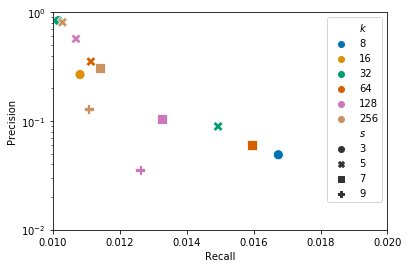

In [24]:
#df_res = pd.read_csv('TFBS_variants_prediction_MA0495.1_01.csv')
#mpl.rcParams['figure.dpi'] = 100

sns.scatterplot(data=df_res[df_res.clust!=4].rename(columns={'k':'$s$','clust':'$k$'}),
            x='recall',y='precision',
                hue='$k$',style='$s$',
               legend="full",palette=sns.color_palette("colorblind", 6),
               s=100)
#plt.plot([1e-2,1e-2],[0,1],'k',linewidth=1,zorder=0)
#plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2,1)
plt.xlim(1e-2,2e-2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [25]:
df_kmer = pd.DataFrame([],columns=['variants','known'])

df_kmer.loc[0,'variants'] = set(sample.motif_seq.tolist())
df_kmer.loc[0,'known'] = df_res.known.iloc[0]

def get_prc(df_res):
    df_res['tp'] = df_res.apply(lambda x: x.known.intersection(x.variants),axis=1)
    df_res['fp'] = df_res.apply(lambda x: x.variants-x.known.intersection(x.variants),axis=1)
    df_res['fn'] = df_res.apply(lambda x: x.known-x.known.intersection(x.variants),axis=1)
    df_res['precision'] = df_res.apply(lambda x: len(x.tp)/(len(x.tp)+len(x.fp)),axis=1)
    df_res['recall'] = df_res.apply(lambda x: len(x.tp)/(len(x.tp)+len(x.fn)),axis=1)
    return df_res

df_kmer = get_prc(df_kmer)
df_kmer

,variants,known,tp,fp,fn,precision,recall
0,"{CCAATGTCAGCAGTTTTA, TCATAGTCATCACTTTAT, ATTGA...","{GCAAAGTCAGCAGAACAA, GTTACGTAAGCAGTATTT, GTCTT...","{CCAATGTCAGCAGTTTTA, TCATAGTCATCACTTTAT, ATTGA...",{},"{GCAAAGTCAGCAGAACAA, GTTACGTAAGCAGTATTT, GTCTT...",1.0,0.010008


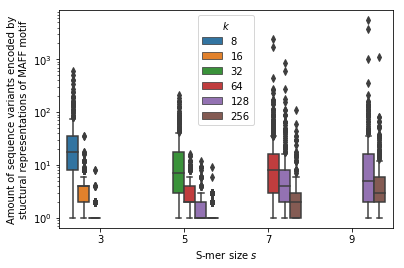

In [26]:
# amonut of unique predicted variants

sample_exp['len_variants'] = sample_exp.variants.apply(len)
sns.boxplot(data=sample_exp.rename(columns={'k':'s','clust':'k'}),
            x='s',hue='k',y='len_variants')
plt.yscale('log')
plt.legend(loc='middle',title='$k$')
plt.ylabel('Amount of sequence variants encoded by\nstuctural representations of MAFF motif')
plt.xlabel('S-mer size $s$')
plt.show()

In [27]:
print(49462/4**18)

7.197668310254812e-07


# Plot initial data

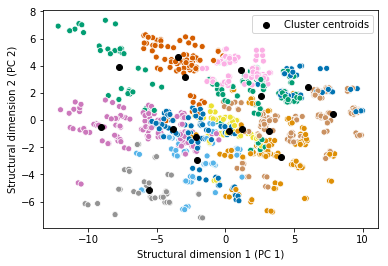

In [29]:
# plot clusters

# load 
# raw data points PCA
# data clusters eg some visualizable number (64)
# data cluster centroids

# f10 = '../../../Clank4A/Script_3_clusters/clusters_bits_9_11_16.mat' # idx5, C5, 
# f11 = '../../../Clank4A/Script_3_clusters/NN5_PCA_strukture_26_5_16.mat' # Z

df_z = pd.read_csv('../data/Z5.csv',header=None)
df_idx = pd.read_csv('../data/idx5_16.csv',header=None)
df_idx.columns = ['idx']
df_c = pd.read_csv('../data/c5_16.csv',header=None)

# multilayered plot
ax = sns.scatterplot(data=pd.concat([df_z,df_idx],axis=1),
               x=0,y=1,hue='idx',
               legend="full",palette=sns.color_palette("colorblind", 16))
plt.scatter(df_c[0],df_c[1],color='k',zorder=1,label='Cluster centroids')
ax.get_legend().remove()
plt.xlabel('Structural dimension 1 (PC 1)')
plt.ylabel('Structural dimension 2 (PC 2)')

current_handles, current_labels = plt.gca().get_legend_handles_labels()
plt.legend([current_handles[-1]],[current_labels[-1]])

plt.show()

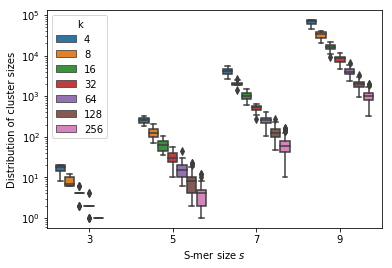

In [30]:
# plot cluster size distributions boxplot

df_idx3 = pd.read_csv('../data/k3_idx.csv',header=None).drop(columns=0)
df_idx5 = pd.read_csv('../data/k5_idx.csv',header=None).drop(columns=0)
df_idx7 = pd.read_csv('../data/k7_idx.csv',header=None).drop(columns=0)
df_idx9 = pd.read_csv('../data/k9_idx.csv',header=None).drop(columns=0)

df_counts = []
for i in df_idx3.columns: 
    tmp = pd.DataFrame(df_idx3[i].value_counts().tolist(),columns=['idx_counts'])
    tmp['s'] = 3
    tmp['k'] = get_clust_from_i(i-1)
    df_counts.append(tmp)
for i in df_idx5.columns: 
    tmp = pd.DataFrame(df_idx5[i].value_counts().tolist(),columns=['idx_counts'])
    tmp['s'] = 5
    tmp['k'] = get_clust_from_i(i-1)
    df_counts.append(tmp)
for i in df_idx7.columns: 
    tmp = pd.DataFrame(df_idx7[i].value_counts().tolist(),columns=['idx_counts'])
    tmp['s'] = 7
    tmp['k'] = get_clust_from_i(i-1)
    df_counts.append(tmp)
for i in df_idx9.columns: 
    tmp = pd.DataFrame(df_idx9[i].value_counts().tolist(),columns=['idx_counts'])
    tmp['s'] = 9
    tmp['k'] = get_clust_from_i(i-1)
    df_counts.append(tmp)
    
df_counts = pd.concat(df_counts)
df_counts

sns.boxplot(data=df_counts,
           x='s',hue='k',y='idx_counts')
plt.yscale('log')
plt.xlabel('S-mer size $s$')
plt.ylabel('Distribution of cluster sizes')
plt.show()

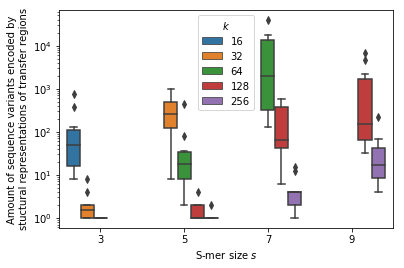

In [31]:
# Plot orit 220 bp predicted sequence variants

# last file holds all data on 10 reps
fn = '../data/temporary_results_var_4.npy'
seqs = np.load(fn)

# dataframe
df_orit = []
for i in range(10):
    tmp = pd.DataFrame(seqs[:,:,i],columns=[4,8,16,32,64,128,256],index=[3,5,7,9]).stack().reset_index()
    tmp['rep'] = i
    df_orit.append(tmp)
    
df_orit = pd.concat(df_orit)
df_orit.columns = ['s','k','count','rep']

# plot
sns.boxplot(data=df_orit,
            x='s',hue='k',y='count')
plt.yscale('log')
plt.legend(loc='middle',title='$k$')
plt.ylabel('Amount of sequence variants encoded by\nstuctural representations of transfer regions')
plt.xlabel('S-mer size $s$')
plt.show()


In [32]:
# compare sizes average num variants

(df_orit[~((df_orit.s==3)&(df_orit.k==64))]
 .groupby(['s','k'])['count']
 .median()
).divide(sample_exp[sample_exp.clust.isin(df_orit.k.unique())]
            .groupby(['k','clust'])
            .len_variants
          .median() 
).mean()

32.28528138528139

In [33]:
# improvements

tmp = pd.read_csv('../data/c4_table2.csv')
print(tmp)

(tmp.iloc[2:,[0,1,4,5]].astype('float').values/(tmp.iloc[1,[0,1,4,5]].astype('float').values)).mean(axis=0)

        r2   r2.1      pval  pval.1       f1   f1.1
0  Pos/Neg    MOB   Pos/Neg     MOB  Pos/Neg    MOB
1    0.017  0.113     0.472   0.473    0.892  0.834
2    0.046  0.237    < 1e-4  < 1e-4    0.955  0.853
3    0.049  0.248    < 1e-4  < 1e-4    0.942  0.923
4    0.054  0.253  1.00E-04  < 1e-4     0.97  0.923
5    0.057  0.264  1.00E-04  < 1e-4    0.954  0.879


array([3.02941176, 2.21681416, 1.07090807, 1.07254197])